$$\text{Smart Regonition Model: Hand Gestures}$$

In [9]:
import os
import cv2

In [10]:
# Create a new directory to store dataset of images for hand recognition

def makedir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        pass

In [72]:
curr_dir = os.getcwd()

# Dataset directory
data_dir = curr_dir + "\\hand_gestures_ds"
makedir(data_dir)

# Training directory + training gestures
train_data_dir = data_dir+"\\train"
makedir(train_data_dir)

train_data_dir_ges = train_data_dir+"\\train_Rthumbs_up"
makedir(train_data_dir_ges)

train_data_dir_ges = train_data_dir+"\\train_Rthumbs_down"
makedir(train_data_dir_ges)

train_data_dir_ges = train_data_dir+"\\train_Rindex_up"
makedir(train_data_dir_ges)

train_data_dir_ges = train_data_dir+"\\train_Rindex_down"
makedir(train_data_dir_ges)

# Validation directory + Validation gestures
valid_data_dir = data_dir+"\\valid"
makedir(valid_data_dir)

valid_data_dir_ges = valid_data_dir+"\\valid_Rthumbs_up"
makedir(valid_data_dir_ges)

valid_data_dir_ges = valid_data_dir+"\\valid_Rthumbs_down"
makedir(valid_data_dir_ges)

valid_data_dir_ges = valid_data_dir+"\\valid_Rindex_up"
makedir(valid_data_dir_ges)

valid_data_dir_ges = valid_data_dir+"\\valid_Rindex_down"
makedir(valid_data_dir_ges)

In [79]:
def record_gesture(dir, gesture_dir, ges, num_frames):
    # Initialize the webcam and check if webcam was opened correctly
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Webcam was not opened successfully.")

    # Begin the data collection process
    try:
        frame_count = 0
        i = 0
        while i < 2:
            full_dir_path = os.path.join(dir, gesture_dir)            
            ret, frame = cap.read()
            
            # If frame is read correctly, succesful_ret is True
            if not ret:
                print("Can't receive frame.")
                break
            
            frame = cv2.flip(frame, 1)

            # Process the ROI, save the frame
            roi = frame[100:400, 320:620]
            roi = cv2.resize(roi, (256, 256), interpolation=cv2.INTER_AREA)
            cv2.imshow('Processed Frame', roi)
            
            # Draw rectangle for ROI and display the frame with the ROI
            copy = frame.copy()
            cv2.rectangle(copy, (320, 100), (620, 400), (255, 0, 0), 5)

            if i == 0:
                frame_count = 0
                cv2.putText(copy, "Hit [ENTER] When Ready To Record!", (10,80), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 1)
            if i == 1 and frame_count < num_frames:
                frame_count += 1
                cv2.putText(copy, f"Recording {ges} - Train", (10,80), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 1)
                cv2.putText(copy, str(frame_count), (10,420), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 3)
                img_name = os.path.join(full_dir_path, f"{frame_count}.jpg")
                cv2.imwrite(img_name, roi)
            elif frame_count == num_frames: 
                cv2.putText(copy, "Hit [ENTER] To Exit!", (10,80), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 1)
            cv2.imshow('Frame', copy)
            if cv2.waitKey(1) == 13:
                frame_count = 0
                i += 1

    finally:
        # Release the VideoCapture object and close display window
        cap.release()
        cv2.destroyAllWindows()

In [89]:
# Record different gestures
record_gesture(valid_data_dir, "valid_Rindex_down", "Right Index Down", 175)

In [120]:
from keras.preprocessing.image import ImageDataGenerator 

# Define your data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Random rotation between -20 to 20 degrees
    width_shift_range=0.2,   # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Random zoom
    fill_mode='nearest'      # Strategy for filling in newly created pixels
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256,256),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(256,256),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

Found 2000 images belonging to 4 classes.
Found 700 images belonging to 4 classes.


In [146]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

model1 = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # Fourth convolutional block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # Flattening the layers and adding dense layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Summary of the model architecture
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_15 (Ba  (None, 254, 254, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_16 (Ba  (None, 125, 125, 64)     

In [147]:
from keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Training the model
history = model1.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
63/63 [==============================] - 68s 1s/step - loss: 0.9056 - accuracy: 0.7120 - val_loss: 30.2781 - val_accuracy: 0.2500
Epoch 2/10
63/63 [==============================] - 68s 1s/step - loss: 0.5095 - accuracy: 0.8170 - val_loss: 29.4349 - val_accuracy: 0.2500
Epoch 3/10
63/63 [==============================] - 69s 1s/step - loss: 0.4302 - accuracy: 0.8485 - val_loss: 60.4946 - val_accuracy: 0.2500
Epoch 4/10
63/63 [==============================] - 71s 1s/step - loss: 0.3728 - accuracy: 0.8670 - val_loss: 58.1313 - val_accuracy: 0.2500
Epoch 5/10
63/63 [==============================] - 75s 1s/step - loss: 0.2593 - accuracy: 0.9015 - val_loss: 85.1135 - val_accuracy: 0.2500
Epoch 6/10
63/63 [==============================] - 77s 1s/step - loss: 0.3043 - accuracy: 0.8905 - val_loss: 34.5079 - val_accuracy: 0.2500
Epoch 7/10
63/63 [==============================] - 75s 1s/step - loss: 0.2189 - accuracy: 0.9135 - val_loss: 28.8030 - val_accuracy: 0.2500
Epoch 8/10
63

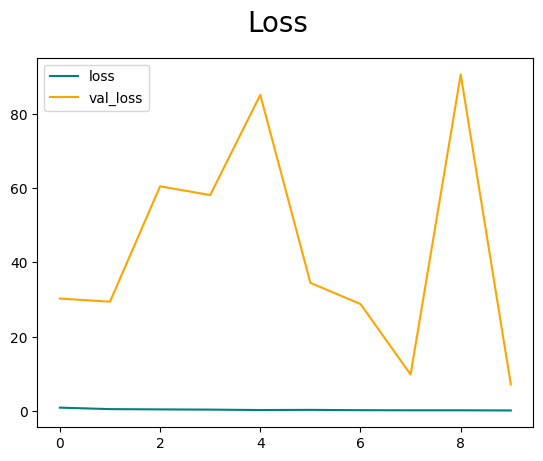

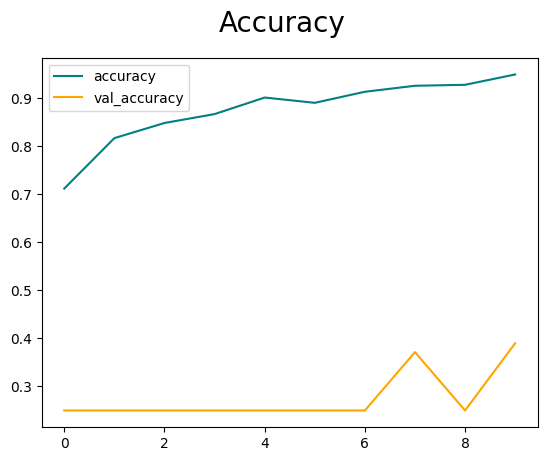

c:\Users\golde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [148]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

model1.save('model1.h5')

In [121]:
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import Dense, Dropout
from keras.models import Model

# Load MobileNetV2 pre-trained on ImageNet without its top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=4, pooling='avg')

# Freeze the base_model
base_model.trainable = True

# Create a new model on top
x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x) 
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# View the structure of the model
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_20[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']     

In [122]:
from keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

train_samples = 2000
valid_samples = 700
epochs = 10

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_samples // 32,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_samples // 32,
    callbacks=[early_stopping]
)

Epoch 1/10
62/62 [==============================] - 85s 1s/step - loss: 0.3413 - accuracy: 0.8892 - val_loss: 1.2734 - val_accuracy: 0.6027
Epoch 2/10
62/62 [==============================] - 80s 1s/step - loss: 0.0249 - accuracy: 0.9949 - val_loss: 0.8883 - val_accuracy: 0.7054
Epoch 3/10
62/62 [==============================] - 81s 1s/step - loss: 0.0135 - accuracy: 0.9959 - val_loss: 0.5820 - val_accuracy: 0.7991
Epoch 4/10
62/62 [==============================] - 81s 1s/step - loss: 0.0137 - accuracy: 0.9949 - val_loss: 1.0776 - val_accuracy: 0.6711
Epoch 5/10
62/62 [==============================] - 83s 1s/step - loss: 0.0072 - accuracy: 0.9975 - val_loss: 1.7302 - val_accuracy: 0.5789
Epoch 6/10
62/62 [==============================] - 83s 1s/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 1.6019 - val_accuracy: 0.6042
Epoch 7/10
62/62 [==============================] - 82s 1s/step - loss: 0.0093 - accuracy: 0.9959 - val_loss: 1.6112 - val_accuracy: 0.6682
Epoch 8/10
62/62 [==

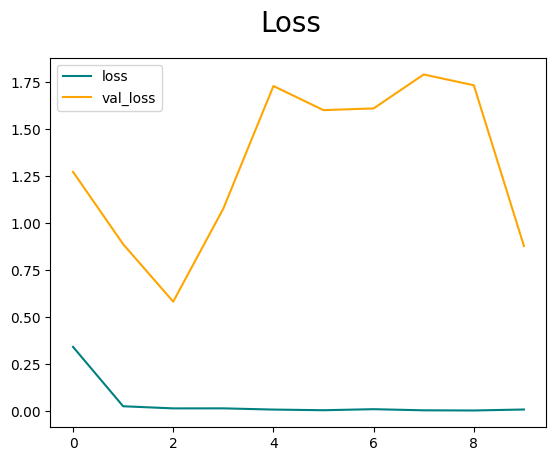

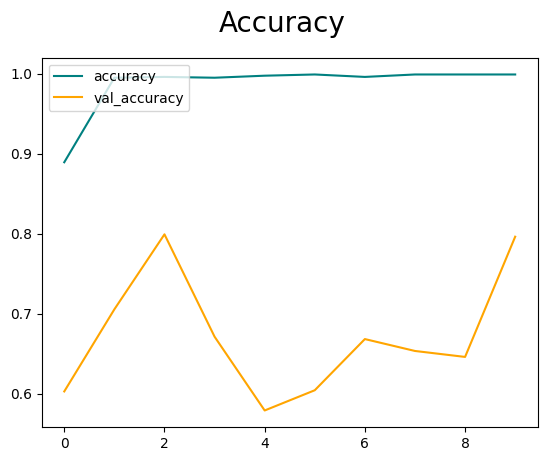

In [123]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

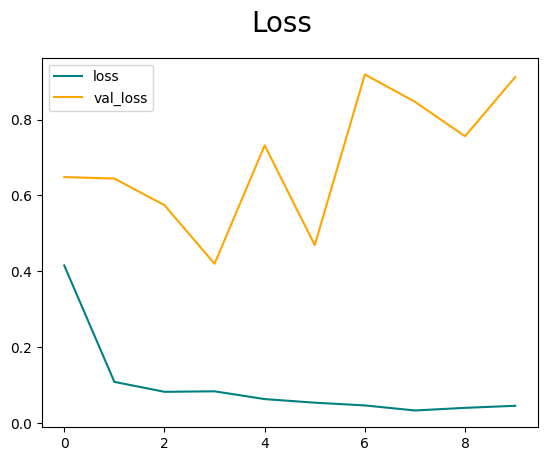

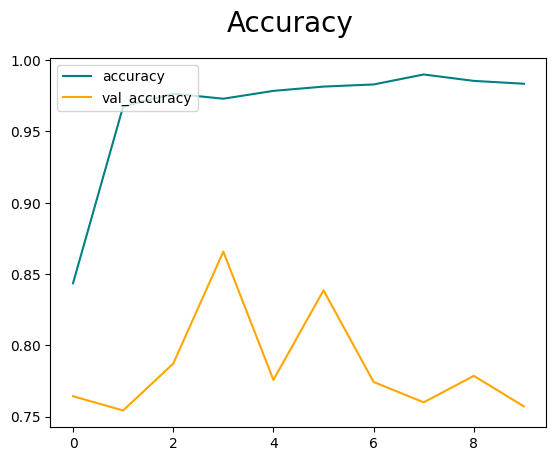

c:\Users\golde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [145]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

model.save('model2.h5')

In [141]:
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import Dense, Dropout
from keras.models import Model

# Load MobileNetV2 pre-trained on ImageNet without its top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=4, pooling='avg')

base_model.trainable = False

# Create a new model on top
x = base_model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x) 
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
# View the structure of the model
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_33[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']     

In [142]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
63/63 [==============================] - 27s 411ms/step - loss: 0.4153 - accuracy: 0.8435 - val_loss: 0.6485 - val_accuracy: 0.7643
Epoch 2/10
63/63 [==============================] - 26s 409ms/step - loss: 0.1083 - accuracy: 0.9675 - val_loss: 0.6446 - val_accuracy: 0.7543
Epoch 3/10
63/63 [==============================] - 26s 408ms/step - loss: 0.0821 - accuracy: 0.9765 - val_loss: 0.5743 - val_accuracy: 0.7871
Epoch 4/10
63/63 [==============================] - 26s 407ms/step - loss: 0.0834 - accuracy: 0.9730 - val_loss: 0.4199 - val_accuracy: 0.8657
Epoch 5/10
63/63 [==============================] - 26s 410ms/step - loss: 0.0629 - accuracy: 0.9785 - val_loss: 0.7321 - val_accuracy: 0.7757
Epoch 6/10
63/63 [==============================] - 26s 409ms/step - loss: 0.0534 - accuracy: 0.9815 - val_loss: 0.4691 - val_accuracy: 0.8386
Epoch 7/10
63/63 [==============================] - 26s 409ms/step - loss: 0.0462 - accuracy: 0.9830 - val_loss: 0.9191 - val_accuracy: 0.7743

In [17]:
import cv2
import numpy as np
import pyautogui
import screen_brightness_control as sbc
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img

cap = cv2.VideoCapture(0)

model = load_model('model2.h5')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    # Process the ROI, save the frame
    roi = frame[100:400, 320:620]
    roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)  # Resize to match model's expected input
    cv2.imshow('Processed Frame', roi)
    image = img_to_array(roi)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    
    # Draw rectangle for ROI and display the frame with the ROI
    copy = frame.copy()
    cv2.rectangle(copy, (320, 100), (620, 400), (255, 0, 0), 5)
    result = np.argmax(model.predict(image), axis=1)
    if result == [0]:
        cv2.putText(copy, str("index down"), (300,100), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)
        pyautogui.press('volumedown')
    elif result == [1]:
        cv2.putText(copy, str("index up"), (300,100), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)
        pyautogui.press('volumeup')
    elif result == [2]:
        cv2.putText(copy, str("thumbs down"), (300,100), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)
        if(sbc.get_brightness()[0] < 100):
            sbc.set_brightness(sbc.get_brightness()[0] + 1)
    elif result == [3]:
        cv2.putText(copy, str("thumbs up"), (300,100), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)
        if(sbc.get_brightness()[1] > 0):
            sbc.set_brightness(sbc.get_brightness()[0] - 1, display=0)
    cv2.imshow('frame', copy)

    if cv2.waitKey(1) == 13:
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 35ms/step


In [13]:
from keras.models import load_model

model = load_model('model2.h5')

In [26]:
from keras.preprocessing.image import img_to_array, load_img
image = load_img('hand_gestures_ds\\valid\\valid_Rthumbs_up\\100.jpg', target_size=(224, 224))
image = img_to_array(image)
image = image / 255.0
image = np.expand_dims(image, axis=0)

np.argmax(model.predict(image), axis=1)

1/1 [==============================] - 0s 31ms/step


array([3], dtype=int64)